In [1]:
seed = 66

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
np.set_printoptions(suppress=True)
np.random.seed(seed)
from mpl_toolkits.axes_grid1 import ImageGrid
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import time

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from unet import UNetModel

import tqdm
import torch.nn.functional as F

##  Load Data

In [3]:
# In[2]

#Data Processing
data = pd.read_csv("F:data/BeijingLoad.csv", header=None)
ori_data = np.array(data)

#Gramian Angular Field
from pyts.image import GramianAngularField
transformer = GramianAngularField(sample_range=(0,1),method='s')

ori_gasf,scaled_data = transformer.transform(ori_data)

#ori_data——原始的365天负荷数据
#scaled_data——归一化后的365天负荷数据
#ori_gasf——完整的格拉姆角场图，365天
scaled_data = np.where(scaled_data>=1.,1.,scaled_data)
scaled_data = np.where(scaled_data<= -1.,-1.,scaled_data)

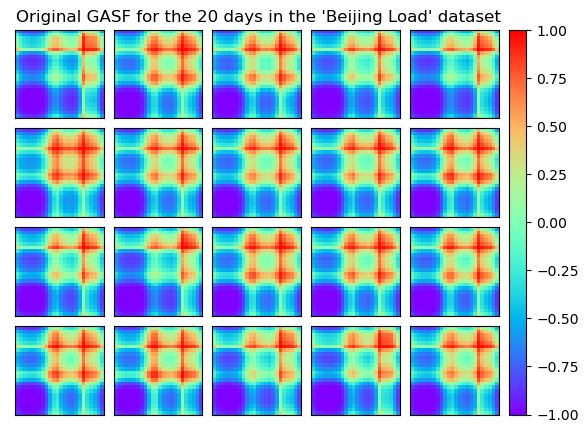

In [4]:
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(ori_gasf[i], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Original GASF for the 20 days in the "
             "'Beijing Load' dataset", y=0.92)

plt.show()

new_transformer = GramianAngularField(sample_range=None,method='s')

In [5]:
#Data Split

train_set = ori_gasf[:300]
test_set = ori_gasf[300:]

batch_size = 20
n_steps=200

#取出GAF图像
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle = True,drop_last=True)

##  Train Diffusion Network

In [6]:
# Train network
net = UNetModel(image_size=24, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.train()
print('Network parameters:', sum([p.numel() for p in net.parameters()]))

Network parameters: 22078017


In [7]:
def compute_schedule(T, beta_min, beta_max, device):
    betas = torch.linspace(beta_min, beta_max, steps=T, device=device)
    alphas = 1 - betas

    std_t = torch.sqrt(betas)
    alpha_bar = torch.cumprod(alphas, dim=0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

    schedule_hparams = {
        "std_t": std_t,
        "alphas": alphas,
        "sqrt_alpha_bar": sqrt_alpha_bar,
        "sqrt_one_minus_alpha_bar": sqrt_one_minus_alpha_bar,
        "oneover_sqrta": 1 / torch.sqrt(alphas),
        "mab_over_sqrtmab": (1 - alphas) / sqrt_one_minus_alpha_bar,
    }
    return schedule_hparams

def sample(T, schedule, img_shape, unet, device):
    with torch.no_grad():
        seed = torch.randn(*img_shape).to(device=device)
        for i in range(T, 0, -1):
            z = torch.randn(*img_shape).to(device=device) if i > 1 else 0
            ts = torch.ones(1).to(device) * i

            pred_eps = net(seed, ts.float())
            term1 = schedule["oneover_sqrta"][i - 1]
            term2 = seed - (schedule["mab_over_sqrtmab"][i - 1] * pred_eps)
            term3 = z * schedule["std_t"][i - 1]

            seed = term1 * term2 + term3

        return seed

In [8]:
# HyperParameters
T = 1000
beta_min = 1e-4
beta_max = 0.02
epochs = 100
lr = 0.0001
update_every = 20

device = "cuda" if torch.cuda.is_available() else "cpu"

schedule = compute_schedule(T, beta_min, beta_max, device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [9]:
loss_list = []

In [10]:
print("Training process initializing .....\n")

for e in range(epochs):
    acc_loss, denom = 0.0,0.0

    for i, batch in enumerate(train_loader):
        x = batch
        x = x.unsqueeze(1)
        x = x.to(device)
        x = x.float()
        
        # Forward diffuse
        ts = torch.randint(1, T + 1, (x.shape[0],), device=device)
        eps = torch.randn_like(x, device=device)

        
        x_pass = (
            schedule["sqrt_alpha_bar"][ts - 1] [..., None, None, None] * x
            + schedule["sqrt_one_minus_alpha_bar"][ts - 1][..., None, None, None] * eps
            
        )
       
    
        # Pass through network
        pred = net(x_pass.float(), ts.float())
        
        # Compute loss and backprop
        loss = torch.nn.MSELoss()(pred, eps)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc_loss += loss.item()
        denom += x.shape[0]
        
    #print('[Epoch {}]'.format(e+1))
    print('[Epoch {}],loss: {: .8f}'.format(e+1, acc_loss/denom))
    loss_list.append(acc_loss/denom)
  


Training process initializing .....

[Epoch 1],loss:  0.04466147
[Epoch 2],loss:  0.03233746
[Epoch 3],loss:  0.02162017
[Epoch 4],loss:  0.01348247
[Epoch 5],loss:  0.00798098
[Epoch 6],loss:  0.00479883
[Epoch 7],loss:  0.00351548
[Epoch 8],loss:  0.00213999
[Epoch 9],loss:  0.00168123
[Epoch 10],loss:  0.00135344
[Epoch 11],loss:  0.00119286
[Epoch 12],loss:  0.00114793
[Epoch 13],loss:  0.00115042
[Epoch 14],loss:  0.00138720
[Epoch 15],loss:  0.00147001
[Epoch 16],loss:  0.00113650
[Epoch 17],loss:  0.00094648
[Epoch 18],loss:  0.00089155
[Epoch 19],loss:  0.00089313
[Epoch 20],loss:  0.00112798
[Epoch 21],loss:  0.00091526
[Epoch 22],loss:  0.00066248
[Epoch 23],loss:  0.00088665
[Epoch 24],loss:  0.00088168
[Epoch 25],loss:  0.00080767
[Epoch 26],loss:  0.00098356
[Epoch 27],loss:  0.00088754
[Epoch 28],loss:  0.00074322
[Epoch 29],loss:  0.00099561
[Epoch 30],loss:  0.00095169
[Epoch 31],loss:  0.00090820
[Epoch 32],loss:  0.00081692
[Epoch 33],loss:  0.00074829
[Epoch 34],loss

In [11]:
loss_list

[0.04466147025426229,
 0.032337456345558166,
 0.02162017007668813,
 0.013482465595006942,
 0.007980983977516492,
 0.004798833553989728,
 0.003515475653111935,
 0.0021399878958861035,
 0.0016812326076130072,
 0.001353443842381239,
 0.0011928612117966017,
 0.001147926061724623,
 0.0011504219193011521,
 0.0013871950966616471,
 0.0014700102992355824,
 0.001136496402323246,
 0.0009464756802966197,
 0.0008915474234769742,
 0.000893132866670688,
 0.0011279844554762046,
 0.0009152625221759081,
 0.000662479215922455,
 0.0008866538867975275,
 0.0008816776874785622,
 0.0008076749555766583,
 0.0009835594271620114,
 0.0008875369063268106,
 0.0007432155217975378,
 0.0009956050291657448,
 0.0009516867560644944,
 0.000908200421060125,
 0.000816918583586812,
 0.0007482911832630635,
 0.0007408060614640514,
 0.00075374658840398,
 0.0007995744080593188,
 0.0008077457516143719,
 0.0008801154637088378,
 0.0010510729905217886,
 0.0006481639528647065,
 0.0009319880108038585,
 0.0007625129322210947,
 0.0007557

In [16]:
noise = torch.randn((24,24))

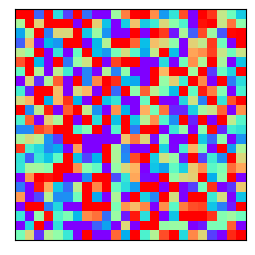

In [19]:

plt.figure(figsize=(3, 3))

plt.imshow(noise,cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
ax = plt.gca()

ax.set_xticks([])
ax.set_yticks([])

plt.savefig

plt.savefig("noise_input.png")

In [12]:
train_loss = np.array(loss_list)

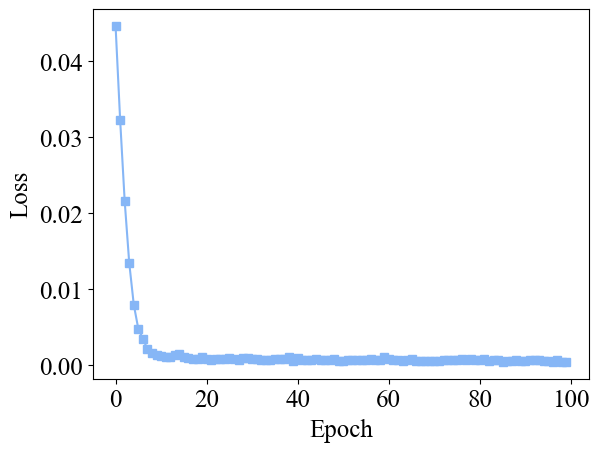

In [15]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}

plt.xticks(fontproperties = 'Times New Roman', size = 18)
plt.yticks(fontproperties = 'Times New Roman', size = 18)

plt.ylabel("Loss",font)  # 设置Y轴标签
plt.xlabel("Epoch",font)  # 设置X轴标签

ln1, = plt.plot(train_loss,color='#86B6F6', marker='s')

plt.savefig("train_loss.svg")

In [20]:
sampled_imgs = sample(T, schedule, (1,1,24,24), net, device)

In [13]:
sampled_imgs.shape

torch.Size([1, 1, 24, 24])

In [21]:
x = sampled_imgs

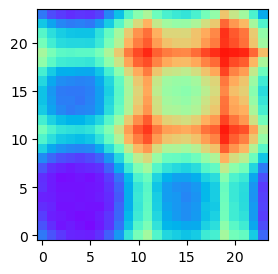

In [22]:
# Visualize sample

x = x.squeeze(0)
x = x.squeeze(0)

plt.figure(figsize=(3,3))
plt.imshow(x.cpu().numpy(),cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
plt.show()

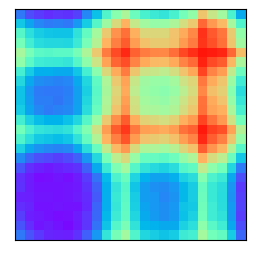

In [24]:

plt.figure(figsize=(3, 3))

plt.imshow(x.cpu().numpy(),cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
ax = plt.gca()

ax.set_xticks([])
ax.set_yticks([])


plt.savefig("ddpm_output.png")

In [11]:
'''
# Save/Load model
torch.save(net.state_dict(), 'unet_new.pth')
print('Saved model')
'''

Saved model
